# Assignment 3 - Part 2

In this assignment, you are to architect a neural network to perform text classification.

Grading scheme:

- Model: 10
- Training: 10
- Test accuracy: 20

```
    >= 70%: 5/10
    >= 75%: 10/20
    >= 80%: 15/20
    >= 85%: 20/20
```

Total: 40

In [1]:
"🔒"
import torch
from torch import (nn, optim)
from torch.utils.data import (Dataset, DataLoader, random_split)
from torchsummaryX import summary
import pandas as pd
import numpy as np
import warnings
import test_lib
from importlib import reload
reload(test_lib)
warnings.filterwarnings('ignore')

## Load dataset and vocabulary from file

You are given two dataset files for training and testing.

In [2]:
"🔒"
train_dataset = torch.load('./train_dataset.npz')
test_dataset = torch.load('./test_dataset.npz')

print("Training dataset: %d" % len(train_dataset))
print("Test dataset: %d" % len(test_dataset))

Training dataset: 20000
Test dataset: 5000


## Load the vocabulary

You are given the vocabulary file.  This is used **only** for decoding
the integers in the dataset.  It is not used for training, nor testing.

In [3]:
"🔒"
vocab = torch.load('./vocab.pt')
print("There are %d tokens in vocabulary." % len(vocab))

There are 2000 tokens in vocabulary.


## Check data

In [4]:
"🔒"
# @check
# @title: data integrity

x, y = train_dataset[100]
print("Review:", " ".join(vocab.lookup_tokens(x.numpy().tolist())))
print("Label:", y.item())

Review: one of the very best three <unk> <unk> ever . a <unk> house full of evil guys and the <unk> <unk> the <unk> detective <unk> s best men . <unk> is in top form in the famous in the dark scene . <unk> <unk> provides excellent support in his mr . <unk> role as the <unk> of a murder plot . before it s over <unk> s <unk> little <unk> is <unk> to great effect . this minute gem moves about as fast as any <unk> s short and <unk> twice the <unk> . highly recommended . <pad> <pad> <pad>
Label: 1


## Model

Construct a model that can process and learn from the samples from dataset.

**Hints:**  Learn advanced architectural layers:

- LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- Conv1D: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
- MaxPool1d: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
- Dropout: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [171]:
"✍️"
# @workUnit

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), 32)
        self.conv1d = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.8)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, 128, num_layers=6, batch_first=True)
        self.fc = nn.Linear(128, 2)
    def forward(self, x):
        out = self.embedding(x)
        out = out.transpose(1, 2)
        out = self.conv1d(out)
        out = self.ReLU(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = out.transpose(1, 2)
        y, (s, c) = self.lstm(out)
        return self.fc(c[0])


In [172]:
"🔒"
# @check
# @title: verify model output

model = MyModel()
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
xs, targets = next(iter(dataloader))
model(xs).shape

torch.Size([128, 2])

## Training

Implement a function `train` that will train the model.

Inputs are:

- model: an instance of the `MyModel`
- train_dataset: a dataset to be trained on.
- epochs: the number of epochs
- max_batches: optional integer that will limit the number of batches per epoch.

Returns a Pandas DataFrame will columns: `train_loss` and `train_acc` which are
the training loss and accuracy per epoch.

**Hint:**

- Start with a simple model, and make sure that you can get a decent performance.
- Start with a small number of `max_batches` to make sure you get a decent training accuracy.
- Output debugging message with timing information, so you can estimate the training duration.
- For good test accuracy, you need `max_matches ~ 500` and 20 epochs or more.

In [173]:
"✍️"
# @workUnit
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: %s" % device)

# print the number of model parameters
print("Number of parameters: %d" % sum(p.numel() for p in model.parameters()))
def train(model: MyModel, train_dataset: Dataset, epochs: int, max_batches=None) -> pd.DataFrame:
    
    model = model.to(device)    
    dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    loss_fn = loss_fn.to(device)
    optimzer = optim.Adam(model.parameters())
    history = {
        'train_loss': [],
        'train_acc': []
    }
    start0 = time.time()
    total, succ = 0.0, 0.0
    for epoch in range(epochs):
        start = time.time()
        for i, (xs, targets) in enumerate(dataloader):
            xs, targets = xs.to(device), targets.to(device)
            optimzer.zero_grad()
            y = model(xs)
            loss = loss_fn(y, targets)
            loss.backward()
            optimzer.step()
            history['train_loss'].append(loss.item())
            with torch.no_grad():
                pred = y.argmax(axis=-1)
                succ += (pred == targets).sum().item()
                total += len(targets)
                history['train_acc'].append(succ / total)
            if i % 10 == 0:
                print("Batch %d: train_loss=%.4f, train_acc=%.4f" % (i, loss.item(), history['train_acc'][-1]))
            if max_batches is not None and i >= max_batches:
                break
        duration = time.time() - start
        print("[Epoch [%d/%d]: train_loss=%.4f, train_acc=%.4f [%.2f Seconds]]" % (epoch, epochs, np.mean(history['train_loss']), history['train_acc'][-1], duration))
    duration0 = time.time() - start0
    print("Training finished in %.2f Seconds" % duration0)
    return pd.DataFrame(history)


Using device: cuda
Number of parameters: 830274


In [174]:
%%time
"✍️"
# @workUnit

#
# train the model
#
model = MyModel()
hist = train(model, train_dataset, epochs=20, max_batches=500)

Batch 0: train_loss=0.6942, train_acc=0.5312
Batch 10: train_loss=0.7029, train_acc=0.4908
Batch 20: train_loss=0.6914, train_acc=0.5000
Batch 30: train_loss=0.6848, train_acc=0.5078
Batch 40: train_loss=0.6884, train_acc=0.5147
Batch 50: train_loss=0.6774, train_acc=0.5190
Batch 60: train_loss=0.7245, train_acc=0.5151
Batch 70: train_loss=0.6837, train_acc=0.5154
Batch 80: train_loss=0.6844, train_acc=0.5152
Batch 90: train_loss=0.6916, train_acc=0.5146
Batch 100: train_loss=0.6899, train_acc=0.5144
Batch 110: train_loss=0.6981, train_acc=0.5137
Batch 120: train_loss=0.6829, train_acc=0.5139
Batch 130: train_loss=0.7046, train_acc=0.5151
Batch 140: train_loss=0.7074, train_acc=0.5151
Batch 150: train_loss=0.6816, train_acc=0.5161
[Epoch [0/20]: train_loss=0.6943, train_acc=0.5163 [3.44 Seconds]]
Batch 0: train_loss=0.6912, train_acc=0.5166
Batch 10: train_loss=0.6845, train_acc=0.5163
Batch 20: train_loss=0.7019, train_acc=0.5167
Batch 30: train_loss=0.7005, train_acc=0.5162
Batch 40:

In [175]:
"🔒"
# @check
# @title: verify dataframe columns

hist.columns

Index(['train_loss', 'train_acc'], dtype='object')

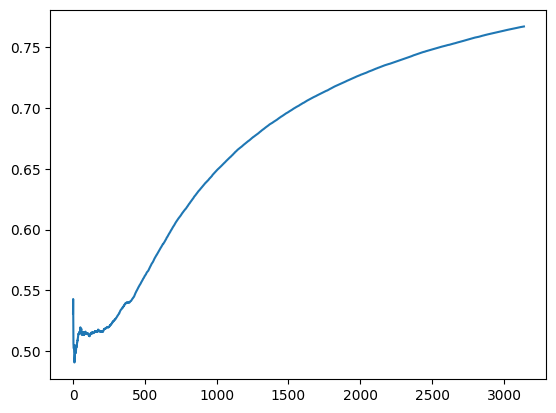

In [176]:
"🔒"
#
# Plot the training accuracy
#
hist.train_acc.plot.line();

In [177]:
"🔒"
#
# Save the entire model to disk
#
torch.save(model, 'mymodel.pt')

## Testing

The following code evaluates your model using `test_dataset`.

In [182]:
"🔒"
#
# Test your current model in memory
#

test_lib.test_saved_model(model)

Saved model has test accuracy = 81.04


In [183]:
"🔒"
#
# Test your saved model on disk
#
test_lib.test_saved_model()

Loading from mymodel.pt
Saved model has test accuracy = 81.12
